In [9]:

from monai.transforms import Affine, Rand2DElastic,Flip,ToTensor
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import shutil
import os

## Setup data directory

In [3]:

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/xindong/project/data


In [5]:
resource = "https://warwick.ac.uk/fac/sci/dcs/research/tia/" \
    + "glascontest/download/warwick_qu_dataset_released_2016_07_08.zip"
md5 = None

compressed_file = os.path.join(
    root_dir, "warwick_qu_dataset_released_2016_07_08.zip")
data_dir = os.path.join(root_dir, "Warwick QU Dataset (Released 2016_07_08)")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

In [6]:
img_name = os.path.join(data_dir, "train_22.bmp")
seg_name = os.path.join(data_dir, "train_22_anno.bmp")
im = np.array(PIL.Image.open(img_name))
seg = np.array(PIL.Image.open(seg_name))

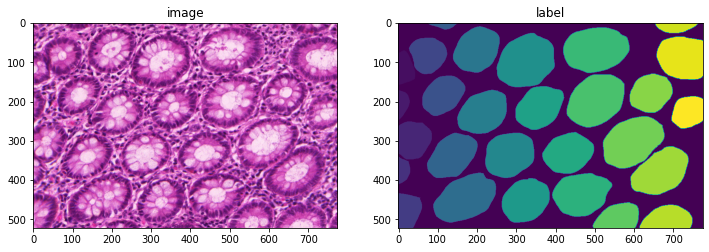

(522, 775, 3) (522, 775)


In [7]:

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(seg)
plt.show()
print(im.shape, seg.shape)

In [14]:
flip = Flip(
    spatial_axis=[0],
)
#randf_data_dict = randF(data_dict)
randf_data_dict = flip(im)
print(f"image shape: {randf_data_dict.shape}")
# print(f"image pixdim:\n{randf_data_dict['img_meta_dict']['pixdim']}")

image shape: (522, 775, 3)


## Affine transformation

In [6]:
# MONAI transforms always take channel-first data: [channel x H x W]
im_data = np.moveaxis(im, -1, 0)  # make them channel first
seg_data = np.expand_dims(seg, 0)  # make a channel for the segmentation

print(im_data.shape)
print(seg_data.shape)

# create an Affine transform
affine = Affine(
    rotate_params=np.pi / 4,
    scale_params=(1.2, 1.2),
    translate_params=(200, 40),
    padding_mode="zeros",
    device=torch.device("cuda:0"),
)
# convert both image and segmentation using different interpolation mode
new_img, _ = affine(im_data, (300, 400), mode="bilinear")
new_seg, _ = affine(seg_data, (300, 400), mode="nearest")
print(new_img.shape, new_seg.shape)

(3, 522, 775)
(1, 522, 775)
(3, 300, 400) (1, 300, 400)


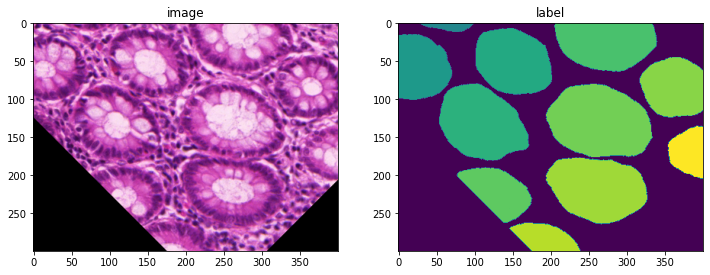

In [7]:

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(np.moveaxis(new_img.astype(int), 0, -1))
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(new_seg[0].astype(int))
plt.show()

## Elastic deformation

In [11]:
# create an elsatic deformation transform
deform = Rand2DElastic(
    prob=1.0,
    spacing=(30, 30),
    magnitude_range=(5, 6),
    rotate_range=(np.pi / 4,),
    scale_range=(0.2, 0.2),
    translate_range=(100, 100),
    padding_mode="zeros",
    device=torch.device("cuda:0"),
)
# transform both image and segmentation using different interpolation mode
deform.set_random_state(seed=123)
new_img = deform(im_data, (224, 224), mode="bilinear")
deform.set_random_state(seed=123)
new_seg = deform(seg_data, (224, 224), mode="nearest")
print(new_img.shape, new_seg.shape)

(3, 224, 224) (1, 224, 224)


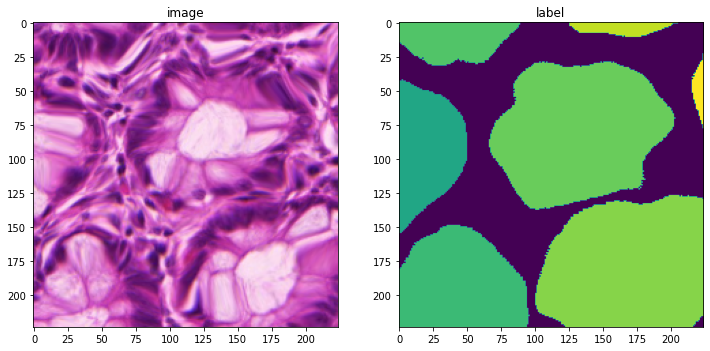

In [13]:
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(np.moveaxis(new_img.astype(int), 0, -1))
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(new_seg[0].astype(int))
plt.show()